In [22]:
import numpy as np
from numpy import linalg as LA
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from scipy.linalg import sqrtm
from numpy.linalg import matrix_rank
from jax.numpy import linalg as jla
from scipy.linalg import logm, expm
from google.colab import files
import copy
import numba
from numba import int64, float64, jit, njit, vectorize
import matplotlib.pyplot as pl

Code for computing Pauli and density operatrors 

In [23]:
def pauli(x):
    if x==0:
        return np.array([[1,0],[0,1]])
    if x==1:
        return np.array([[0,1],[1,0]])
    if x==2:
        return np.array([[0,-1j],[+1j,0]])
    if x==3:
        return np.array([[1,0],[0,-1]])
    else:
        print('invalid')

#qubit
def qubit(x):
    if x==0:
        return np.array([1,0])
    if x==1:
        return np.array([0,1])
    else:
        print('invalid')

def theta(th):
    return np.cos(th/2)*qubit(0)+ np.sin(th/2)*qubit(1)

@njit
def rhom_jit(delta:float64,g:float64) -> (float64[:,:]):
    return np.array([[delta, g],[g, 1-delta]],dtype=float64)

Computing Helstrom success probability for two given density matrices

In [24]:
def helstrom(density_mat1,density_mat2):
  r1=density_mat1
  r2=density_mat2
  l,v=jla.eigh(r1-r2)
  return l,v

def helstrom_success_form(rho0,rho1):
  l,vec=helstrom(rho0,rho1)
  return 0.5*(1+0.5*np.sum(np.abs(l)))

def helstrom_success_rho(rho0,rho1):
  l,vec=helstrom(rho0,rho1)
  v_pos_eig = jnp.array(vec[:,l>0])
  v_pos_eigh= jnp.conjugate(jnp.transpose(v_pos_eig))
  p1=jnp.trace(v_pos_eigh @ rho0 @ v_pos_eig)
  p2=1-jnp.trace(v_pos_eigh@ rho1 @ v_pos_eig)
  return 0.5*(p1+p2)


Computing Von-neumann and channel entropy

In [33]:
def von_neumann(rho):
    rho_log=logm(rho,False)[0]/np.log(2)
    return -jnp.trace(rho@rho_log)
def matrix_power(m,power):
    if power==1:
        return m
    else:
        return matrix_power(m,power-1)@m
'''
code to compute logarithm of matrix

'''
def matrix_log(m):
    l=jnp.zeros(jnp.shape(m))
    for i in range(1,50):
        l=l+(-1)**(i+1)*matrix_power(m-jnp.eye(jnp.shape(m)[0]),i)/i
    return l/np.log(2)

def von_neumann1(rho):
    rho_log=matrix_log(rho)
    return -jnp.trace(rho@rho_log)
'''
code to compute conditional entropy using matrix_log
'''
def cond_ent1(rho,unitary):
    r0=rho
    u=unitary
    r1=u@r0@jnp.transpose(jnp.conjugate(u))
    return 1+von_neumann1(r0)-von_neumann1(0.5*(r0+r1))
def cond_ent_chan(w0,w1):
  return 1+0.5*von_neumann(w0)+0.5*von_neumann(w1)-von_neumann(0.5*w0+0.5*w1)
def cond_ent_chan1(w0,w1):
  return 1+0.5*von_neumann1(w0)+0.5*von_neumann(w1)-von_neumann(0.5*w0+0.5*w1)
def channel_entropy(r,r1):
  return 1+0.5*von_neumann(r)+0.5*von_neumann(r1)-von_neumann(0.5*r+0.5*r1)


Finding dual channel for a CQ channel which outputs a qubit density operator

In [26]:
def dual_chan_dim2(d,g,u):
  r=rhom_jit(d,g)
  r1=u@r@np.conjugate(np.transpose(u))
  l0,v0=LA.eig(r)
  v1=np.zeros(np.shape(v0))
  v1[:,0]=pauli(1)@v0[:,0]
  v1[:,1]=pauli(1)@v0[:,1]
  q0=qubit(0)
  q1=qubit(1)
  p0=np.outer(q0,q0)
  p1=np.outer(q0,q1)
  p2=np.outer(q1,q0)
  p3=np.outer(q1,q1)
  t0=np.sqrt(l0[0])*np.sqrt(l0[0])*np.kron(p0,p0)+np.sqrt(l0[0])*np.sqrt(l0[1])*v0[:,0]@v1[:,1]*np.kron(p1,p0)+np.sqrt(l0[0])*np.sqrt(l0[0])*v0[:,0]@v1[:,0]*np.kron(p1,p1)
  t1=np.sqrt(l0[1])*np.sqrt(l0[1])*np.kron(p0,p3)+np.sqrt(l0[0])*np.sqrt(l0[1])*v0[:,0]@v1[:,1]*np.kron(p1,p3)+np.sqrt(l0[1])*np.sqrt(l0[1])*v0[:,1]@v1[:,1]*np.kron(p1,p2)
  t2=np.sqrt(l0[1])*np.sqrt(l0[1])*np.kron(p3,p0)+np.sqrt(l0[1])*np.sqrt(l0[0])*v0[:,1]@v1[:,0]*np.kron(p2,p0)+np.sqrt(l0[1])*np.sqrt(l0[1])*v0[:,1]@v1[:,1]*np.kron(p2,p1)
  t3=np.sqrt(l0[0])*np.sqrt(l0[0])*np.kron(p3,p3)+np.sqrt(l0[1])*np.sqrt(l0[0])*v0[:,1]@v1[:,0]*np.kron(p2,p3)+np.sqrt(l0[0])*np.sqrt(l0[0])*v0[:,0]@v1[:,0]*np.kron(p2,p2)

  return 0.5*(t0+t1+t2+t3)


Sample code to calculate dual channel

In [45]:
r=rhom_jit(0.08,0.05)
print('channel:\n',r)
r1=pauli(1)@r@pauli(1)
dualr=dual_chan_dim2(0.08,0.05,pauli(1))
print('channel:\n',dualr)
dualr1=np.kron(pauli(3),np.eye(2))@dualr@np.kron(pauli(3),np.eye(2))
print('dual_channel1:\n',dualr1)

channel:
 [[0.08 0.05]
 [0.05 0.92]]
channel:
 [[ 0.03851714  0.          0.13238809 -0.00455322]
 [ 0.          0.46148286  0.05455322  0.13238809]
 [ 0.13238809  0.05455322  0.46148286  0.        ]
 [-0.00455322  0.13238809  0.          0.03851714]]
dual_channel1:
 [[ 0.03851714  0.         -0.13238809  0.00455322]
 [ 0.          0.46148286 -0.05455322 -0.13238809]
 [-0.13238809 -0.05455322  0.46148286  0.        ]
 [ 0.00455322 -0.13238809  0.          0.03851714]]


In [46]:
h=channel_entropy(r,r1)
h1=channel_entropy(dualr,dualr1)
print('channel entropy:',h)
print('dual channel entropy:',h1)
print('Sum:',h+h1)

channel entropy: 0.39886767
dual channel entropy: 0.6011324
Sum: 1.0


Dual channel for BSC

In [28]:
r=rhom_jit(0.08,0)
print('channel:\n',r)
r1=pauli(1)@r@pauli(1)
dualr=dual_chan_dim2(0.08,0,pauli(1))
print('channel:\n',dualr)
dualr1=np.kron(pauli(3),np.eye(2))@dualr@np.kron(pauli(3),np.eye(2))
print('dual_channel1:\n',dualr1)
u=np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])
#print(u)
ef=u@dualr@np.transpose(u)
ef1=np.reshape(ef,(2,2,2,2))
#print(np.reshape(ef,(2,2,2,2)))
ef1=np.einsum('ijkj->ik',ef1)
print('reduced form:\n',ef1)

channel:
 [[0.08 0.  ]
 [0.   0.92]]
channel:
 [[0.04      0.        0.1356466 0.       ]
 [0.        0.46      0.        0.1356466]
 [0.1356466 0.        0.46      0.       ]
 [0.        0.1356466 0.        0.04     ]]
dual_channel1:
 [[ 0.04       0.        -0.1356466  0.       ]
 [ 0.         0.46       0.        -0.1356466]
 [-0.1356466  0.         0.46       0.       ]
 [ 0.        -0.1356466  0.         0.04     ]]
reduced form:
 [[0.08      0.2712932]
 [0.2712932 0.92     ]]


Code to compare bsc and its dual

In [29]:
def bsc_psc(p,u):
  dualr=dual_chan_dim2(p,0,u)
  dualr1=np.kron(pauli(3),np.eye(2))@dualr@np.kron(pauli(3),np.eye(2))
  u_sw=np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])
  ef=u_sw@dualr@np.transpose(u_sw)
  ef1=np.reshape(ef,(2,2,2,2))
  ef1=np.einsum('ijkj->ik',ef1)
  return ef1


In [34]:
def bsc_psc_success(p,u):
  l=len(p)
  bsc=[]
  psc=[]
  for i in range(0,l):
    r=rhom_jit(p[i],0)
    r1=u@r@np.conjugate(np.transpose(u))
    h=helstrom_success_rho(r,r1)
    ps=bsc_psc(p[i],u)
    ps1=pauli(3)@ps@pauli(3)
    h1=helstrom_success_rho(ps,ps1)
    bsc.append(h)
    psc.append(h1)
  return bsc,psc

def bsc_psc_entropy(p,u):
  l=len(p)
  bsc=[]
  psc=[]
  tot=[]
  for i in range(0,l):
    r=rhom_jit(p[i],0)
    r1=u@r@np.conjugate(np.transpose(u))
    h=channel_entropy(r,r1)
    ps=bsc_psc(p[i],u)
    ps1=pauli(3)@ps@pauli(3)
    h1=channel_entropy(ps,ps1)
    bsc.append(h)
    psc.append(h1)
    tot.append(h+h1)
  return bsc,psc,tot


Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

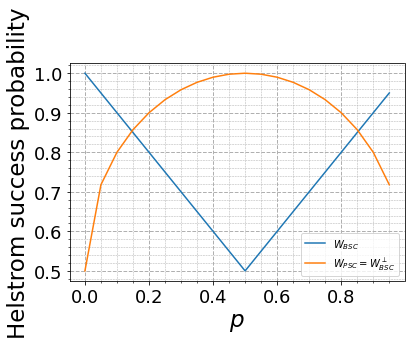

In [43]:
p=np.arange(0,1,0.05)
bsc,psc=bsc_psc_success(p,pauli(1))


pl.plot(p,bsc,linestyle='-',markersize=7.5)
pl.plot(p,psc,linestyle='-',markersize=7.5)
pl.xticks(fontsize=18)

pl.yticks(fontsize=18)
pl.grid(which='major',linestyle='--',linewidth=1)
pl.grid(which='minor', linestyle='--', linewidth='0.5')
pl.minorticks_on()

pl.xlabel(r'$p$',fontsize=23)
pl.ylabel('Helstrom success probability',fontsize=23)
pl.legend((r'$W_{BSC}$',r'$W_{PSC}=W_{BSC}^{\perp}$'),fontsize=10)
pl.savefig("helstrom_success_bsc_psc.pdf",bbox_inches='tight')
files.download("helstrom_success_bsc_psc.pdf")
pl.show()


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

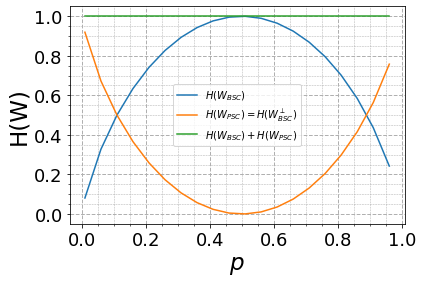

In [42]:
p=np.arange(0.01,1,0.05)
bsc,psc,tot=bsc_psc_entropy(p,pauli(1))


pl.plot(p,bsc,linestyle='-',markersize=7.5)
pl.plot(p,psc,linestyle='-',markersize=7.5)
pl.plot(p,tot,linestyle='-',markersize=7.5)
pl.xticks(fontsize=18)

pl.yticks(fontsize=18)
pl.grid(which='major',linestyle='--',linewidth=1)
pl.grid(which='minor', linestyle='--', linewidth='0.5')
pl.minorticks_on()

pl.xlabel(r'$p$',fontsize=23)
pl.ylabel('H(W)',fontsize=23)
pl.legend((r'$H(W_{BSC})$',r'$H(W_{PSC})=H(W_{BSC}^{\perp})$',r'$H(W_{BSC})+H(W_{PSC})$'),fontsize=10)
pl.savefig("channel_entropy_bsc_psc.pdf",bbox_inches='tight')
files.download("channel_entropy_bsc_psc.pdf")
pl.show()
